# SHAP
## Initialisierung von SHAP
Importieren der benötigten Libraries

In [12]:
import numpy as np
from datasets import load_dataset
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import shap
import requests
from io import BytesIO
import tensorflow as tf

Trainiertes modell und datensatz laden

In [13]:
model = load_model('model_0.781.keras')
dataset = load_dataset("keremberke/pokemon-classification", 'full', split="train")

Hilfsfunktionen

In [14]:
# Bild preprocessing
def preprocess_image(image, target_size):
    if isinstance(image, str):
        # Load the image from a URL
        response = requests.get(image)
        img = load_img(BytesIO(response.content), target_size=target_size)
    else:
        img = image.resize(target_size)
    img_array = img_to_array(img) / 255.0
    return img_array

# Bild analysieren
def analyze_image_url(image_url):
    x_test_sample = preprocess_image(image_url, target_size)
    
    prediction = model(np.array([x_test_sample]))
    prediction_probabilities = tf.nn.softmax(prediction).numpy()
    predicted_class_idx = np.argmax(prediction_probabilities, axis=-1)[0]
    predicted_class_name = sorted(dataset.features['labels'].names)[predicted_class_idx]
    print(f"Model Prediction: {predicted_class_name} (Class Index: {predicted_class_idx})")

    shap_values_ = explainer(np.array([x_test_sample]), max_evals=2000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
    shap.image_plot(shap_values_, labels=list(range(num_classes)))

SHAP initialisieren

In [15]:
target_size = (160, 160)

x_test_mstar = np.array([preprocess_image(sample['image'], target_size) for sample in dataset.select(range(100, 150))])

def f(x):
    tmp = x.copy()
    return model(tmp)

masker_blur = shap.maskers.Image("blur(32,32)", np.array(x_test_mstar[0]).shape)

num_classes = len(dataset.features['labels'].names)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(num_classes)))

## Analyse des Modells
Analyse von Pikachu

Model Prediction: Pikachu (Class Index: 102)


PartitionExplainer explainer: 2it [00:27, 27.11s/it]               


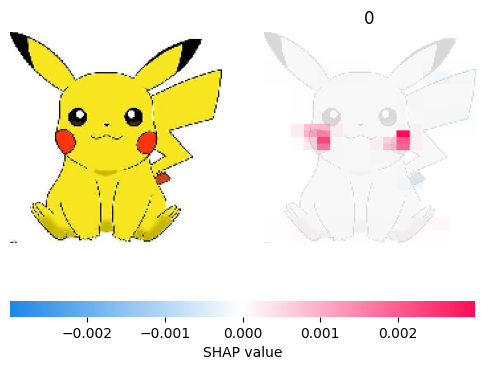

In [17]:
image_url = "https://i.ebayimg.com/images/g/B~gAAOSwhNthhdjn/s-l400.jpg"
analyze_image_url(image_url)

Hier ist deutlich zu erkennen das die wichtigte Eigenschaft für das Modell die roten Backen des Pikachus sind. Daher soll nun geprüft werden wie es sich verhält wenn diese nicht mehr vorhanden sind.

Model Prediction: Pikachu (Class Index: 102)


PartitionExplainer explainer: 2it [00:27, 27.32s/it]               


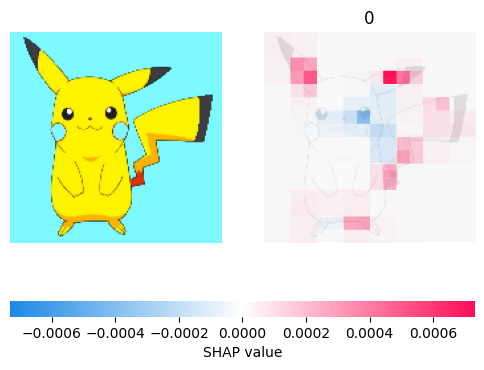

In [18]:
image_url = "https://i.redd.it/heres-a-couple-of-alternate-shinies-for-pikachu-with-v0-bn2u2txa7s6d1.jpg?width=1980&format=pjpg&auto=webp&s=0c83d523d903b23bd54e16f811cd8c3d19d9f5cf"
analyze_image_url(image_url)

Entgegen der annahme wird Pikachu immer noch korrekt erkannt. Stattdesssen fokussiert sich das Modell jetzt auf die Ohren. Zu beachten ist aber auch der niedrigere SHAP wert zu dem Plot davor.
Als nächstes soll daher ein Bild ohne Ohren und Schwanz getestet werden.

Model Prediction: Pikachu (Class Index: 102)


PartitionExplainer explainer: 2it [00:27, 27.69s/it]               


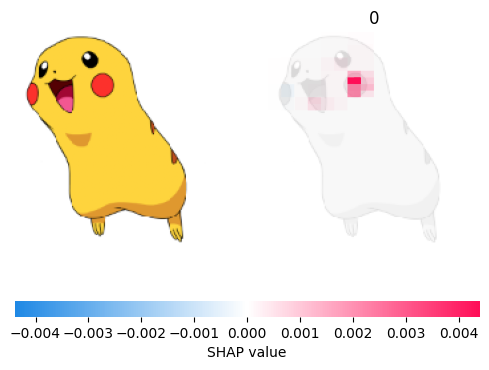

In [19]:
image_url = "https://64.media.tumblr.com/351f1da186047c6983d736c04aeb384d/tumblr_inline_mwxr2bBkWP1rt8g6r.png"
analyze_image_url(image_url)

Model Prediction: Psyduck (Class Index: 110)


PartitionExplainer explainer: 2it [00:28, 28.27s/it]               


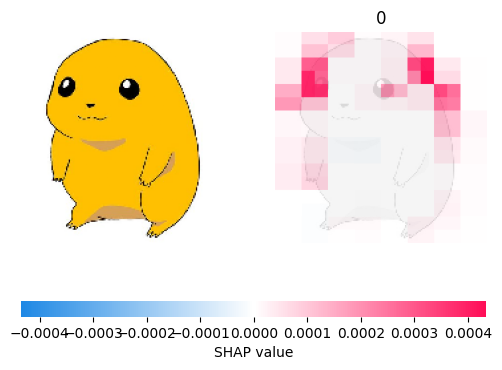

In [16]:
image_url = "https://pbs.twimg.com/media/FZw4aFfX0AAOQud.jpg"
analyze_image_url(image_url)

No red cheeks: https://i.redd.it/heres-a-couple-of-alternate-shinies-for-pikachu-with-v0-bn2u2txa7s6d1.jpg?width=1980&format=pjpg&auto=webp&s=0c83d523d903b23bd54e16f811cd8c3d19d9f5cf
No wings, ears: https://64.media.tumblr.com/351f1da186047c6983d736c04aeb384d/tumblr_inline_mwxr2bBkWP1rt8g6r.png
No wings, ears, cheeks: https://64.media.tumblr.com/a0b81a032e37afd2ae49dd8d0fa54084/tumblr_inline_mwxr7p7Z8L1rt8g6r.png
No wings, ears, cheecks, mouth closed: https://pbs.twimg.com/media/FZw4aFfX0AAOQud.jpg